### Trying to cluster

In [62]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

In [63]:
rsfMRI_info = pd.read_excel("data/TiMeS_rsfMRI_info.xlsx", engine="openpyxl")  
regression_info = pd.read_excel("data/TiMeS_regression_info_processed.xlsx", engine="openpyxl")
rsfMRI_full_info = pd.read_excel("data/TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")
print(regression_info.columns)
print(rsfMRI_info)
regression_info=regression_info[['Stroke_location', 'Lesion_side', 'lesion_volume_mm3']]

Index(['subject_full_id', 'TimePoint', 'Behavioral_assessment', 'MRI',
       'Gender', 'Age', 'Education_level', 'Lesion_side_old', 'Lesion_side',
       'Combined', 'Bilateral', 'Comments', 'Stroke_location',
       'lesion_volume_mm3', 'NIHSS', 'FAB_abstraction', 'FAB_flexibility',
       'FAB_programmation', 'FAB_sensitivity_to_interference',
       'FAB_inhibitory_control', 'FAB_environmental_autonomy', 'FAB_TOT',
       'Stroop_color_time', 'Stroop_color_error', 'Stroop_words_time',
       'Stroop_words_error', 'Stroop_interference_time',
       'Stroop_interference_error', 'Stroop_index_WC', 'Stroop_index_InC',
       'Digit_forward_SPAN', 'Digit_forward_TOTAL', 'Digit_backward_SPAN',
       'Digit_backward_TOTAL', 'Digit_sequencing_SPAN',
       'Digit_sequencing_TOTAL', 'Digit_TOTAL',
       'Fugl_Meyer_right_UPPER_EXTREMITY', 'Fugl_Meyer_right_WRIST',
       'Fugl_Meyer_right_HAND', 'Fugl_Meyer_right_COORDINATION_SPEED',
       'Fugl_Meyer_right_TOTAL', 'Fugl_Meyer_left_UPPER

In [64]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 10, 11, 12, 54, 56, 78, 96, 190, 191, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, regression_info, rsfMRI_full_info, t1_subjects = functions.load_data(folder_path, rois, type='t1_only')
all_matrices, regression_info, rsfMRI_full_info, all_subjects = functions.load_data(folder_path, rois, type='all')
t1_t3_matched, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3_matched')
t1_t4_matched, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4_matched')
t1_t3_matrices, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3')
t1_t4_matrices, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4')
#matrices = functions.matrices_to_wide_df(matrices)

Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [66]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'subject_full_id',
       'Lesion_side', 'Stroke_location', 'lesion_volume_mm3', 'Gender', 'Age',
       'Education_level', 'Combined', 'Bilateral'],
      dtype='object')


##### Cluster for all matrices

In [87]:
def cluster_and_plot(matrices, numerical_cols_names, categorical_cols_name, clusters = 2, plot = True):
    '''
    uses Kmeans clustering to cluster the patients based on their T1 matrices and other features.
    Remark: T1_matrices cannot be 'None' here !
    '''
    
    matrices = matrices.dropna(subset=['T1_matrix'])  # Handle NaN values
    
    # Handle missing values
    matrices.loc[:, categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')
    
    # One-hot encode categorical columns
    matrices_encoded = pd.get_dummies(matrices[categorical_cols_name], drop_first=True)
    print(matrices_encoded.columns)
    
    # Extract numerical column
    numerical_cols = matrices[numerical_cols_names].values

    # Flatten the upper triangle of T1_matrix
    baseline_matrices = matrices['T1_matrix']

    X_matrix = np.array([functions.flatten_upper(m) for m in baseline_matrices])

    # Concatenate all features
    X_combined = np.hstack([X_matrix, matrices_encoded.values, numerical_cols])

    # Scale the combined features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # Perform clustering
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    if plot:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
        plt.title("Patient Clusters at Baseline")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.colorbar(label="Cluster")
        plt.show();
    
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette score: {score}")
    
    subject_ids = matrices.loc[baseline_matrices.index, 'subject_id'].tolist()
    
    # Create a DataFrame with subject IDs and their corresponding cluster labels
    subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

    # Group subjects by cluster label
    grouped_subjects = subject_cluster_df.groupby('cluster')['subject_id'].apply(list).to_dict()

    # Print subjects in each cluster
    for cluster, subjects in grouped_subjects.items():
        print(f"Cluster {cluster}: {subjects}")
    
    # Create a DataFrame mapping subject IDs to their cluster labels
    subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

    # Merge the cluster DataFrame with the original DataFrame (matrices)
    matrices_with_clusters = matrices.merge(subject_cluster_df, on='subject_id', how='left')
    
    return matrices_with_clusters

In [90]:
def cluster_and_plot(matrices, numerical_cols_names, categorical_cols_name, clusters = 2, plot = True):
    '''
    uses Kmeans clustering to cluster the patients based on their T1 matrices and other features.
    Remark: T1_matrices cannot be 'None' here !
    '''
    
    matrices = matrices.dropna(subset=['T1_matrix'])  # Handle NaN values
    
    # Preprocess categorical columns
    matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values
    matrices_encoded = pd.get_dummies(matrices[categorical_cols_name], drop_first=True)
    print(matrices_encoded.columns)
    
    # Extract numerical column
    numerical_cols = matrices[numerical_cols_names].fillna(0).values

    # Flatten the upper triangle of T1_matrix
    baseline_matrices = matrices['T1_matrix']

    X_matrix = np.array([functions.flatten_upper(m) for m in baseline_matrices])

    # Concatenate all features
    X_combined = np.hstack([X_matrix, matrices_encoded.values, numerical_cols])

    # Scale the combined features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # Perform clustering
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    if plot:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
        plt.title("Patient Clusters at Baseline")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.colorbar(label="Cluster")
        plt.show();
    
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette score: {score}")
    
    subject_ids = matrices.loc[baseline_matrices.index, 'subject_id'].tolist()
    
    # Create a DataFrame with subject IDs and their corresponding cluster labels
    subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

    # Group subjects by cluster label
    grouped_subjects = subject_cluster_df.groupby('cluster')['subject_id'].apply(list).to_dict()

    # Print subjects in each cluster
    for cluster, subjects in grouped_subjects.items():
        print(f"Cluster {cluster}: {subjects}")
    
    # Create a DataFrame mapping subject IDs to their cluster labels
    subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

    # Merge the cluster DataFrame with the original DataFrame (matrices)
    matrices_with_clusters = matrices.merge(subject_cluster_df, on='subject_id', how='left')
    
    return matrices_with_clusters

In [91]:
categorical_cols = ['Lesion_side', 'Stroke_location','Education_level','Combined', 'Bilateral']
numerical_cols = ['lesion_volume_mm3','Age','Gender']

all_matrices_labeled = cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
#t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
#t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)

# NORMAL THAT WE GET THE SAME CLUSTERS FOR ALL TIMEPOINTS
# because we are using the same data for clustering (T1)

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')
Silhouette score: 0.03914940046153651
Cluster 0: ['s063', 's012', 's015', 's082', 's071', 's003', 's033', 's045', 's042', 's080', 's073', 's086']
Cluster 1: ['s004']
Cluster 2: ['s009', 's030', 's039', 's055', 's046', 's070', 's048', 's076', 's074']
Cluster 3: ['s007', 's031',

/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_88180/574122195.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values


Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Gender_2.0',
       'Gender_Unknown', 'Age_36.0', 'Age_40.0', 'Age_44.0', 'Age_45.0',
       'Age_47.0', 'Age_48.0', 'Age_49.0', 'Age_54.0', 'Age_56.0', 'Age_57.0',
       'Age_59.0', 'Age_60.0', 'Age_61.0', 'Age_62.0', 'Age_63.0', 'Age_64.0',
       'Age_65.0', 'Age_66.0', 'Age_67.0', 'Age_68.0', 'Age_69.0', 'Age_70.0',
       'Age_71.0', 'Age_72.0', 'Age_73.0', 'Age_74.0', 'Age_75.0', 'Age_76.0',
       'Age_77.0', 'Age_78.0', 'Age_81.0', 'Age_82.0', 'Age_85.0', 'Age_87.0',
       'Age_88.0', 'Age_89.0', '

/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values


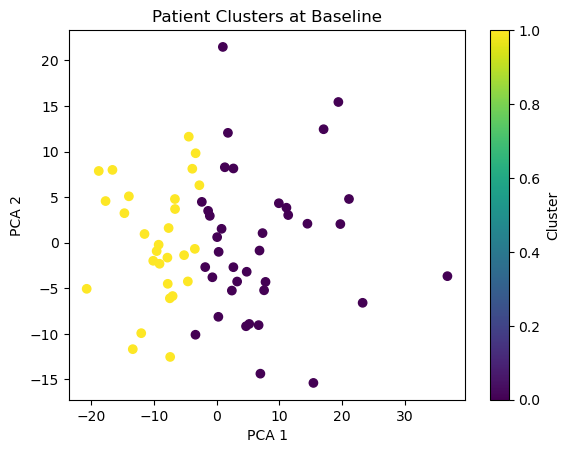

Silhouette score: 0.0738443442804258
Cluster 0: ['s007', 's036', 's062', 's065', 's037', 's039', 's001', 's052', 's063', 's083', 's012', 's015', 's082', 's071', 's047', 's014', 's013', 's025', 's022', 's059', 's068', 's050', 's003', 's060', 's033', 's002', 's029', 's045', 's042', 's080', 's073', 's017', 's021', 's072', 's086', 's081', 's075']
Cluster 1: ['s031', 's009', 's054', 's008', 's030', 's006', 's055', 's041', 's046', 's070', 's048', 's049', 's076', 's078', 's040', 's066', 's057', 's004', 's032', 's051', 's067', 's005', 's027', 's020', 's016', 's011', 's074', 's019']


In [70]:
t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)

### Version Chat payant:

Flattening FC matrices...
Applying PCA...
Testing different cluster numbers...


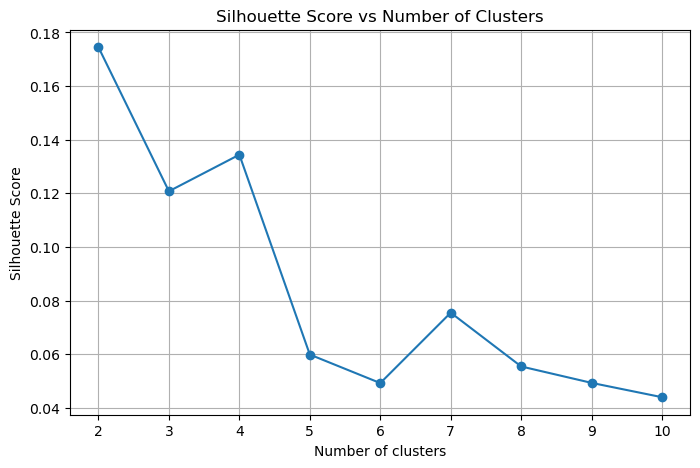

Best number of clusters according to silhouette score: 2


In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def flatten_selected_rois(fc_matrix, selected_rois_labels):
    """
    Flatten connectivities from selected ROIs by label (not by index).
    Args:
        fc_matrix (pd.DataFrame): FC matrix with ROI labels as index and columns.
        selected_rois_labels (list): List of ROI labels to select (e.g., [362, 363, ...])
    """
    flattened = []
    for src_label in selected_rois_labels:
        # Get all connections from this ROI to others
        connections = fc_matrix.loc[src_label, :]  # accès par label
        connections = connections.drop(labels=src_label, errors='ignore')  # enlever self-connection
        flattened.append(connections.values)
    return np.concatenate(flattened)




def cluster_subjects(df, selected_rois_labels, matrix_column='T1_matrix', numerical_cols=None, categorical_cols=None, n_components=20, max_clusters=10, random_state=42):
    """
    Full pipeline to flatten FC matrices, combine clinical features, reduce dimensionality, cluster, and return cluster labels.

    Args:
        df (pd.DataFrame): Input dataframe with subjects
        matrix_column (str): Column containing FC matrices (e.g., 'T1')
        numerical_cols (list): List of numerical column names
        categorical_cols (list): List of categorical column names
        n_components (int): Number of PCA components
        max_clusters (int): Maximum number of clusters to test
        random_state (int): Random seed

    Returns:
        clusters (np.array): Cluster labels
        silhouette_scores (dict): Silhouette scores for different k
        pca_features (np.array): Reduced features (after PCA)
        scaler (StandardScaler): Scaler object (fitted)
        pca (PCA): PCA object (fitted)
    """
    # Flatten T1 FC matrices
    print("Flattening FC matrices...")
    flattened_fc = df[matrix_column].apply(lambda mat: flatten_selected_rois(mat, selected_rois_labels))
    fc_features = np.vstack(flattened_fc.values)

    # Prepare numerical features
    if numerical_cols is not None:
        num_features = df[numerical_cols].values
    else:
        num_features = np.array([]).reshape(len(df), 0)

    # Prepare categorical features
    if categorical_cols is not None and len(categorical_cols) > 0:
        ohe = OneHotEncoder(sparse_output=False, drop='first')
        cat_features = ohe.fit_transform(df[categorical_cols])
    else:
        cat_features = np.array([]).reshape(len(df), 0)

    # Concatenate all features
    all_features = np.hstack([fc_features, num_features, cat_features])

    # Standardize
    scaler = StandardScaler()
    all_features_scaled = scaler.fit_transform(all_features)

    # PCA reduction
    print("Applying PCA...")
    pca = PCA(n_components=n_components, random_state=random_state)
    pca_features = pca.fit_transform(all_features_scaled)

    # Find best k (number of clusters)
    silhouette_scores = {}
    print("Testing different cluster numbers...")
    for k in range(2, max_clusters + 1):
        km = KMeans(n_clusters=k, random_state=random_state)
        labels = km.fit_predict(pca_features)
        score = silhouette_score(pca_features, labels)
        silhouette_scores[k] = score

    # Plot silhouette scores
    plt.figure(figsize=(8,5))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.show()

    # Choose best k
    best_k = max(silhouette_scores, key=silhouette_scores.get)
    print(f"Best number of clusters according to silhouette score: {best_k}")

    # Final KMeans
    kmeans_final = KMeans(n_clusters=best_k, random_state=random_state)
    clusters = kmeans_final.fit_predict(pca_features)

    return clusters, silhouette_scores, pca_features, scaler, pca


# Example of use:
categorical_cols = ['Lesion_side', 'Stroke_location','Education_level','Combined', 'Bilateral']
numerical_cols = ['lesion_volume_mm3','Age','Gender']
selected_rois_indices = [362, 363, 364, 367, 371, 372, 373, 376] 
clusters, silhouette_scores, pca_features, scaler, pca = cluster_subjects(t1_t3_matched, selected_rois_indices, matrix_column='T1_matrix', numerical_cols=numerical_cols, categorical_cols=categorical_cols)
t1_t3_matched['cluster'] = clusters

In [99]:
results = functions.get_sig_matrix(t1_t3_matched, rois, correction=True, alpha=0.05, cluster=False)

TypeError: get_sig_matrix() got an unexpected keyword argument 'correction'

### Beginning of statistical testing


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


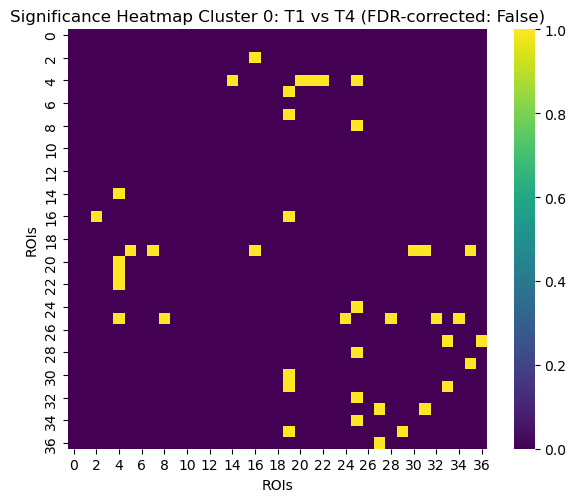


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


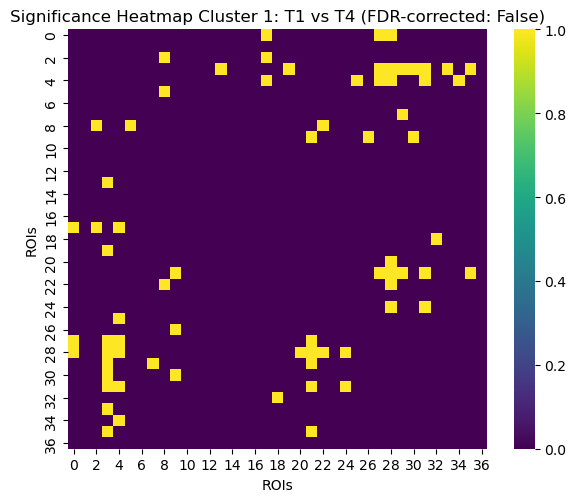

In [ ]:
results = get_sig_matrix(t1_t4_matrices_labeled, tp=4, correction=False, alpha=0.05, cluster=True)

Shape of T1 matrices: (65, 37, 37)
Shape of T3 matrices: (44, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


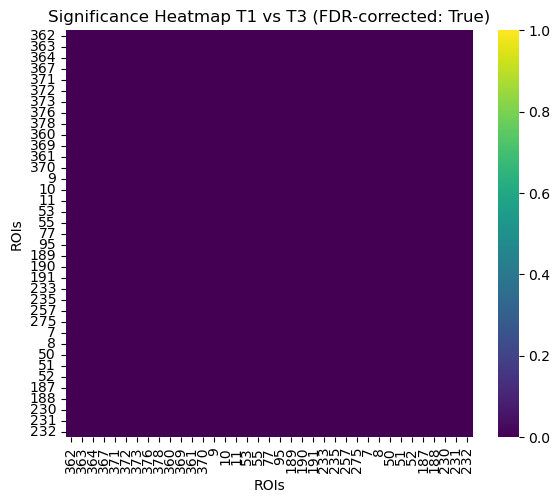

Shape of T1 matrices: (65, 37, 37)
Shape of T3 matrices: (44, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


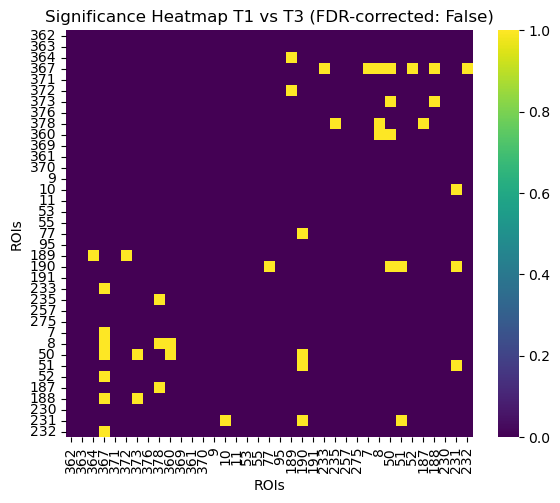


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


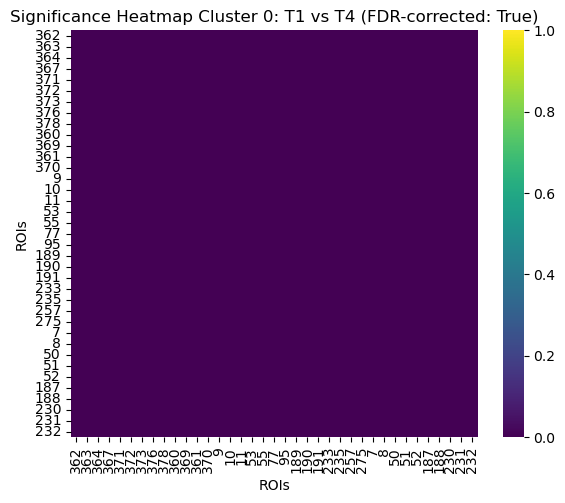


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


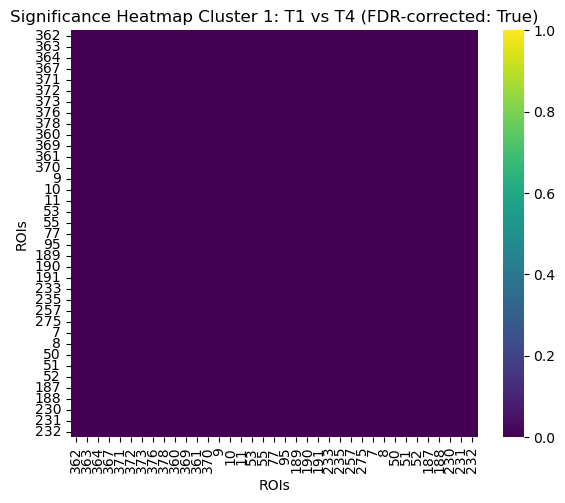


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


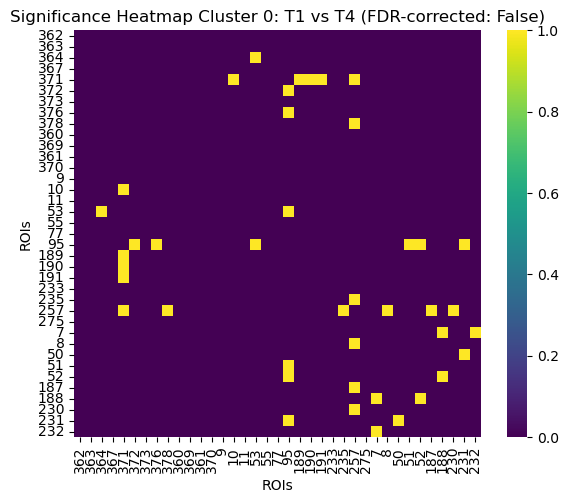


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


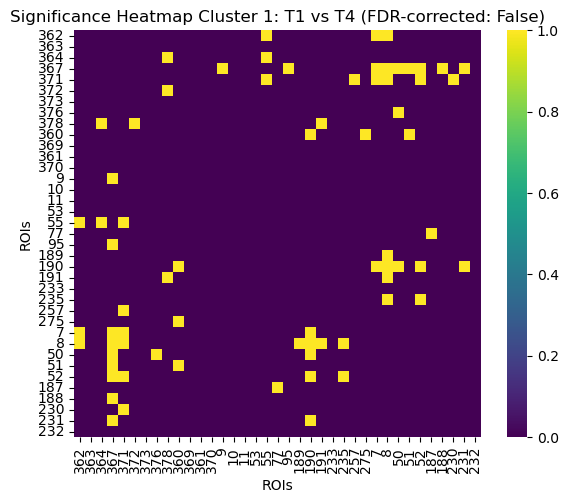

Shape of T1 matrices: (65, 37, 37)
Shape of T4 matrices: (42, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


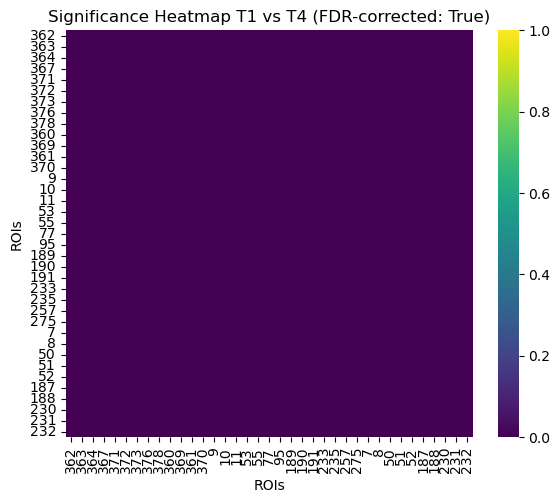

Shape of T1 matrices: (65, 37, 37)
Shape of T4 matrices: (42, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


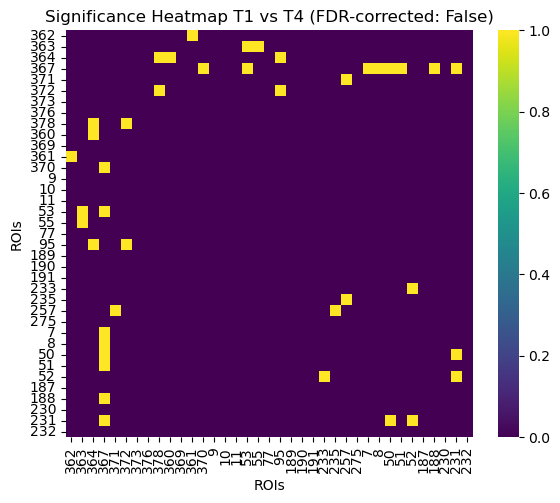

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[       nan, 0.25551029, 0.4015783 , ..., 0.64122593, 0.62244395,
         0.34159699],
        [0.25551029,        nan, 0.52060866, ..., 0.34481731, 0.26292186,
         0.87332444],
        [0.4015783 , 0.52060866,        nan, ..., 0.16426855, 0.37499409,
         0.09500018],
        ...,
        [0.64122593, 0.34481731, 0.16426855, ...,        nan, 0.55472845,
         0.6415112 ],
        [0.62244395, 0.26292186, 0.37499409, ..., 0.55472845,        nan,
         0.50564467],
        [0.34159699, 0.87332444, 0.09500018, ..., 0.6415112 , 0.50564467,
                nan]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [Fal

In [77]:
get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=True, alpha=0.05, cluster=False)
get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=False, alpha=0.05, cluster=False)
get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=True, alpha=0.05, cluster=True)
get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=False, alpha=0.05, cluster=True)
get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=True, alpha=0.05, cluster=False)
get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=False, alpha=0.05, cluster=False)

#### Code to do it by cluster for both T3 and T4

In [ ]:
functions.sig_matrix_T1_T(t1_t4_matrices_labeled, rois, tp = 4, alpha=0.05, cluster = True)

In [ ]:
functions.sig_matrix_T1_T(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True)

In [ ]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)
functions.compare_T1_T_by_cluster(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True)

### Look at difference between FC

In [ ]:
functions.compute_FC_diff(t1_t3_matrices_labeled, tp = 3)

### Regression Analysis